In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# prepare data  Train , Test
from torchvision import datasets
from torch.utils.data import DataLoader

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [266]:
# define model

inc = 28*28
outc = 128
res = 10

#полносвязная сеть
class FCnet(nn.Module):
  def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(inc, outc )
        self.fc2 = nn.Linear(outc, res)
        self.dp1 = nn.Dropout(0.2)

  def forward(self, x):
        x = self.flat(x) # 28*28
        x = self.fc1(x) # 28*28*128
        x = F.relu(x)
        x = self.dp1(x)
        x = self.fc2(x) # 128*10
        output = F.softmax(x, dim=1)
        #output = F.log_softmax(x, dim=1)

        return output

#глубокая сверточная сеть
class   DeepConvnet(nn.Module):
  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5) 
        self.mp1 = nn.MaxPool2d(2) 
        self.act1 = nn.Tanh()
        self.conv2 = nn.Conv2d(8, 24, 3) 
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(600, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.act2 = nn.Softmax()

  def forward(self, x):
        x = self.conv1(x) #out 8x24x24
        x = self.mp1(x) #out 8x12x12
        x = self.act1(x)
        x = self.conv2(x) #out 16x10x10
        x = self.mp1(x) #out 16x5x5
        x = self.act1(x)
        x = self.flat(x) #out 400
        x = self.fc1(x) #out 128
        x = self.act1(x)
        x = self.fc2(x) #out 64
        x = self.act1(x)
        x = self.fc3(x) #out 10
        output = self.act2(x)


        return output

In [5]:
from torchvision import transforms
#collate_fn custom
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        convert = transforms.ToTensor()
        inp = tuple(map(lambda x: convert(x), transposed_data[0]))
        tgt = tuple(map(lambda x: torch.asarray(x), transposed_data[1]))
        self.inp = torch.stack(inp, 0)
        self.tgt = torch.stack(tgt, 0)

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

In [6]:
# prepare data  Train , Test
from torchvision import datasets
from torch.utils.data import DataLoader

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True
)

train_dataloader = DataLoader(training_data, batch_size=64, collate_fn = collate_wrapper,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=512, collate_fn = collate_wrapper,  shuffle=True)

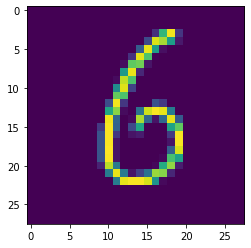

In [7]:
from matplotlib.pyplot import imshow
imshow(training_data.__getitem__(18)[0])

In [195]:
# train model
from torch.nn.modules.loss import CrossEntropyLoss, MSELoss
from torch.optim import SGD
from torchvision import transforms
from numpy import argmax


def train_model(train_ds, model):
    loss_fn = CrossEntropyLoss(reduction='none')
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(1):
      for i, data in enumerate(train_ds):
        inputs = data.inp.to(torch.float32)
        labels = data.tgt.to(torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.mean().backward()

        optimizer.step()
      print('Epoch {} loss equals : {}'.format( epoch, loss.mean() ))
      return loss.mean().detach().numpy()

  


In [147]:
# evaluate model
from sklearn.metrics import accuracy_score
from numpy import vstack

def evaluate(test_ds, model):
  preds , actuals = list(), list()
  for i , data in enumerate(test_ds):
    inputs = data.inp.to(torch.float32)
    labels = data.tgt.to(torch.float32)
    y = model(inputs)
    y = y.detach().numpy()
    actual = labels.numpy()
    y = argmax(y, axis=1)
    actual = actual.reshape((len(actual), 1))
    y = y.reshape((len(y), 1))
    
    preds.append(y)
    actuals.append(actual)

    preds, actuals = vstack(preds), vstack(actuals)
    acc = accuracy_score(actuals, preds)
    return acc

In [212]:
net = FCnet()

In [138]:
train_model(train_dataloader, net)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5465900897979736


In [213]:
loss_list = list()
epoch = list()
acc_list = list()

for i in range(10):
  epoch.append(i)
  loss_list.append(train_model(train_dataloader, net))
  res = []
  for j in range(5):
    res.append(evaluate(test_dataloader,net))
  
  print(f'epoch: {i} , accuracy: {np.mean(res)}')
  acc_list.append(np.mean(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.8223868608474731
epoch: 0 , accuracy: 0.814453125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.6236683130264282
epoch: 1 , accuracy: 0.887109375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5560046434402466
epoch: 2 , accuracy: 0.90859375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.612249732017517
epoch: 3 , accuracy: 0.91484375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5459177494049072
epoch: 4 , accuracy: 0.92265625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5768498182296753
epoch: 5 , accuracy: 0.919921875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5604729652404785
epoch: 6 , accuracy: 0.9375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.5362673997879028
epoch: 7 , accuracy: 0.92890625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.4868730306625366
epoch: 8 , accuracy: 0.933984375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch 0 loss equals : 1.4857192039489746
epoch: 9 , accuracy: 0.937109375


In [219]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

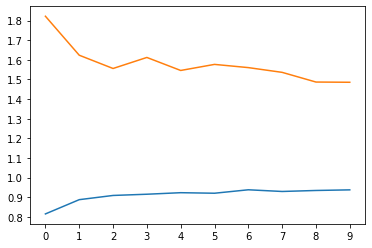

In [224]:
fig , ax = plt.subplots()
plt.plot(epoch, acc_list)
plt.plot(epoch, loss_list)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [267]:
dnet = DeepConvnet()

In [262]:
def train_dmodel(train_ds, model):
    loss_fn = CrossEntropyLoss(reduction='none')
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(1):
      for i, data in enumerate(train_ds):
        inputs = data.inp.to(torch.float32)
        labels = data.tgt.to(torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.mean().backward()

        optimizer.step()
      print('Epoch {} loss equals : {}'.format( epoch, loss.mean() ))
      return loss.mean().detach().numpy()

In [268]:
dloss_list = list()
depoch = list()
dacc_list = list()

for i in range(10):
  depoch.append(i)
  dloss_list.append(train_dmodel(train_dataloader, net))
  res = []
  for j in range(5):
    res.append(evaluate(test_dataloader,net))
  
  print(f'epoch: {i} , accuracy: {np.mean(res)}')
  dacc_list.append(np.mean(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.545790433883667
epoch: 0 , accuracy: 0.961328125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.4655929803848267
epoch: 1 , accuracy: 0.962109375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.4628390073776245
epoch: 2 , accuracy: 0.957421875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.533621907234192
epoch: 3 , accuracy: 0.96328125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.5077455043792725
epoch: 4 , accuracy: 0.962109375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.521791696548462
epoch: 5 , accuracy: 0.965625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.5046483278274536
epoch: 6 , accuracy: 0.967578125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.4837788343429565
epoch: 7 , accuracy: 0.96328125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.4931560754776
epoch: 8 , accuracy: 0.972265625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch 0 loss equals : 1.5086183547973633
epoch: 9 , accuracy: 0.966796875


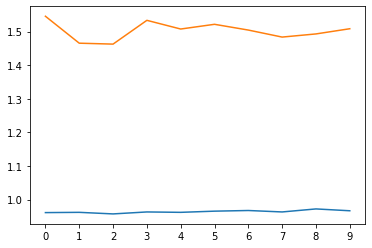

In [269]:
fig , ax1 = plt.subplots()
plt.plot(depoch, dacc_list)
plt.plot(depoch, dloss_list)
ax1.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

Даже простая сверточная сеть c 66 тыс. весов в модели , показывает лучший результат по сравнению с полносвязной сетью с 100 тыс. параметрами модели.